# Skynet Final Project

## Imports

In [4]:
# !pip install torch
# !pip install WordCloud
# !pip install simpletransformers
# !pip install emoji
from numpy import loadtxt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import emoji
import re
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from simpletransformers.classification import ClassificationModel
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

## Data Acquisition

In [5]:
dataset_name = 'ChatgptData.csv' 
bucket_data_name = 'skynet-chatgpt'
data_location = 's3://{}/{}'.format(bucket_data_name, dataset_name)

In [6]:
data = pd.read_csv(data_location) #Loading the data

In [7]:
data = data.head(1000) # This is only the first 1000 data points not the whole data set

## Data Cleanup

In [8]:
data.drop(["Unnamed: 0"], axis = 1,  inplace = True)

In [9]:

data['tweets'][25]

'OpenAI ChatGPT: Optimizing Language Models for Dialogue: https://t.co/5U0hKcwvqR Comments: https://t.co/UhizYWHZsq'

In [10]:
for i in data.index: 
    data['tweets'][i] = emoji.demojize(data['tweets'][i]).replace("_"," ").replace("\\n","").lower()
    data['tweets'][i] = re.sub(r"(https?://[^\s]+)", "", data['tweets'][i])

In [11]:
tweets = list(data['tweets'])
english_punctuations = string.punctuation
punctuations_list = english_punctuations

def cleaning_punctuations(tweets):
    translator = str.maketrans('', '', punctuations_list)
    return tweets.translate(translator)

data['tweets']= data['tweets'].apply(lambda x: cleaning_punctuations(x))
data['tweets'].tail()

995    top story guyp ok so openais new chatgpt can b...
996    conspiracy theory chatgpt is gpt4 being beta t...
997                              chatgpt saluting face  
998    writing react components with chatgpt and tail...
999    so here suddenly chatgpt thinks elon musk is t...
Name: tweets, dtype: object

In [12]:
data['tweets'][4]

'as of 2 minutes ago openai released their new chatgpt and you can use it right now backhand index pointing down  '

## Data Exploration

In [13]:
data.groupby('labels').count()

,tweets
labels,
bad,417
good,316
neutral,267


In [14]:
data.describe(include='all')

,tweets,labels
count,1000,1000
unique,968,3
top,openai debuts chatgpt and gpt35 series as gpt4...,bad
freq,5,417


In [15]:
data.isnull().sum()

tweets    0
labels    0
dtype: int64

## Data Visualization

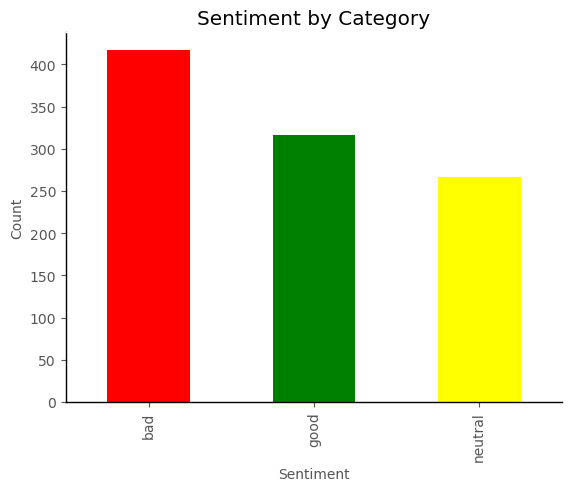

In [16]:
plt.style.use('ggplot')

colors = ['red','green','yellow']
ax = data['labels'].value_counts().sort_index().plot(kind='bar', color=colors,title='Sentiment by Category')
ax.set_xlabel('Sentiments')
ax.set_facecolor('White')
plt.xlabel('Sentiment', fontsize=10)
plt.ylabel('Count', fontsize=10)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.grid(False)
plt.show()

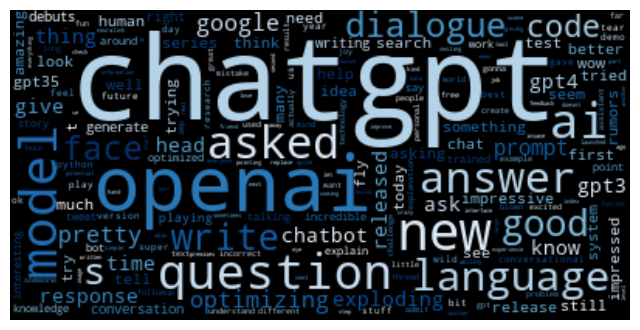

In [17]:
text = " ".join([x for x in data.tweets])
stopwords= set(STOPWORDS)
stopwords_update = stopwords.union(['Im','way','Ive','now','even','will','going','dont','made','v','lot','open',
                                    'gets','got','really','use','cant','make','n','one','using','take','yet','might','via'])
wordcloud = WordCloud(background_color='black', collocations=False,colormap="Blues",stopwords=stopwords_update).generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

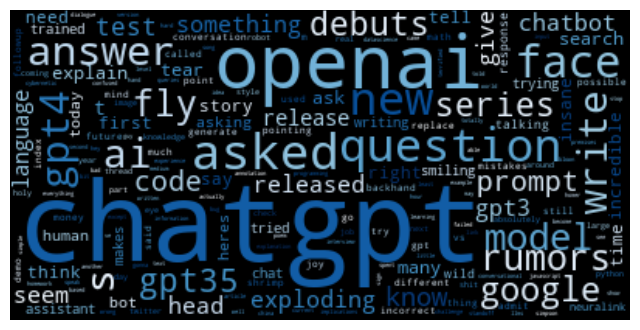

In [18]:
text = " ".join([x for x in data.tweets[data.labels=='bad']])

stopwords= set(STOPWORDS)
stopwords_update = stopwords.union(['Im','way','Ive','now','even','will','going','dont','made','v','lot','open',
                                    'gets','got','really','use','cant','make','n','one','using','take','yet','might','via'])
wordcloud = WordCloud(background_color='black', collocations=False,colormap="Blues",stopwords=stopwords_update).generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Preprocessing

In [19]:
###### identifying the new values for label column!
data['labels'] = data['labels'].replace(['bad','neutral','good'],[0,1,2]) 

In [20]:
train,validate = train_test_split(data,test_size = 0.25, random_state = 123)

In [21]:
model = ClassificationModel('bert', 'bert-base-cased', num_labels=3, 
                            args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=True)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [22]:
def label_categories(label):
    if(label=='good'):
        return 2
    elif(label=='neutral'):
        return 1
    else:
        return 0
    
train['label'] = train['labels'].apply(label_categories)
validate['label'] = validate['labels'].apply(label_categories)
print(train.shape)

(750, 3)


In [23]:
train_df = pd.DataFrame({
    'tweets': train['tweets'].replace(r'\n', ' ', regex=True),
    'label': train['labels']
})

In [24]:
train_df

,tweets,label
894,chatgpt spitting bars,0
941,research gonna be a bit different now i guess ...,1
285,chatgpt is some wild ass tech like wow uhthe f...,1
462,i know it’s too much to ask for but i tested c...,0
370,chatgpt,0
...,...,...
988,holy shit chatgpt is really good,0
322,woops just gave the ai an existential crisis c...,0
382,chatgpt is writing almost fully functional who...,2
365,openais new chatgpt is very good at creative w...,2


In [25]:
validate_df = pd.DataFrame({
    'tweets': validate['tweets'].replace(r'\n', ' ', regex=True),
    'label': validate['labels']
})

In [26]:
validate_df

,tweets,label
131,this aint elizatry the new openai chatgpt here...,0
203,some years ago chatbots and conversational int...,2
50,i just spent a bunch of time discussing differ...,0
585,chatgpt can mix four different languages then ...,2
138,openai’s new chatgpt appears to defeat hofstad...,0
...,...,...
653,chatgpt is incredible,0
11,openai chatgpt optimizing language models for ...,1
252,ive been dipping my toe into every major ai te...,0
521,just asked openai chatgpt to suggest me some r...,0


## Training Model

In [27]:
model.train_model(train_df)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/94 [00:00<?, ?it/s]

(94, 1.030629962682724)

## Model Outputs

In [28]:
result, model_outputs, wrong_predictions = model.eval_model(validate_df)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/250 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]

In [29]:
result

{'mcc': 0.40334283217385525, 'eval_loss': 0.8692026138305664}

In [30]:
model_outputs

array([[ 4.11376953e-01,  2.44445801e-02,  3.35449219e-01],
       [-2.98828125e-01, -1.31835938e-01,  1.18652344e+00],
       [ 3.37890625e-01,  1.20300293e-01,  4.77050781e-01],
       [-2.14111328e-01, -6.67114258e-02,  1.18652344e+00],
       [ 9.99023438e-01, -2.06909180e-01, -5.92651367e-02],
       [ 6.16699219e-01, -1.43798828e-01,  1.55761719e-01],
       [ 1.14135742e-02,  2.58300781e-01,  6.93359375e-01],
       [ 1.06054688e+00, -3.26416016e-01, -2.05688477e-01],
       [ 2.40966797e-01, -2.72750854e-03,  4.86083984e-01],
       [ 1.49511719e+00, -4.93896484e-01, -6.92382812e-01],
       [ 1.46850586e-01,  1.26342773e-01,  5.83984375e-01],
       [ 2.24731445e-01,  1.30859375e-01,  5.72265625e-01],
       [ 1.38574219e+00, -8.27636719e-01, -7.72460938e-01],
       [ 5.31738281e-01, -5.15365601e-03,  2.89794922e-01],
       [-3.65722656e-01,  5.53283691e-02,  1.16015625e+00],
       [ 3.53515625e-01,  1.05590820e-01,  4.50195312e-01],
       [-5.63659668e-02,  1.95434570e-01

In [31]:
wrong_predictions

[{'guid': 2, 'text_a': 'i just spent a bunch of time discussing different organizational models with openais new chatgpt incredible ', 'text_b': None, 'label': 0},
 {'guid': 15, 'text_a': 'ok just ran a little test of openais new chatgpt and flushed face', 'text_b': None, 'label': 1},
 {'guid': 18, 'text_a': 'gpt3 chatgpt is awesomei can not imagina how many things gp4 will be able to doopenai gpt3 ', 'text_b': None, 'label': 2},
 {'guid': 27, 'text_a': 'using chatgpt to write creepy twosentence stories ', 'text_b': None, 'label': 1},
 {'guid': 30, 'text_a': 'is there an ideal personal knowledge management system what are its characteristicschatgpt ', 'text_b': None, 'label': 2},
 {'guid': 34, 'text_a': 'interesting that chatgpt doesnt talk about going to college when i ask it about how to learn any topic', 'text_b': None, 'label': 1},
 {'guid': 38, 'text_a': 'absolutely insane i asked chatgpt to generate a simple personal website it showed step by step on how to create it then added h

In [32]:
true = validate_df['label'].tolist()
outputs_list = []
for arr in model_outputs:
    outputs_list.append(np.argmax(arr))
predicted = outputs_list
#sklearn.metrics.classification_report(true,predicted,target_names=['positive','neutral','negative'])
sklearn.metrics.accuracy_score(true,predicted)

0.612

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

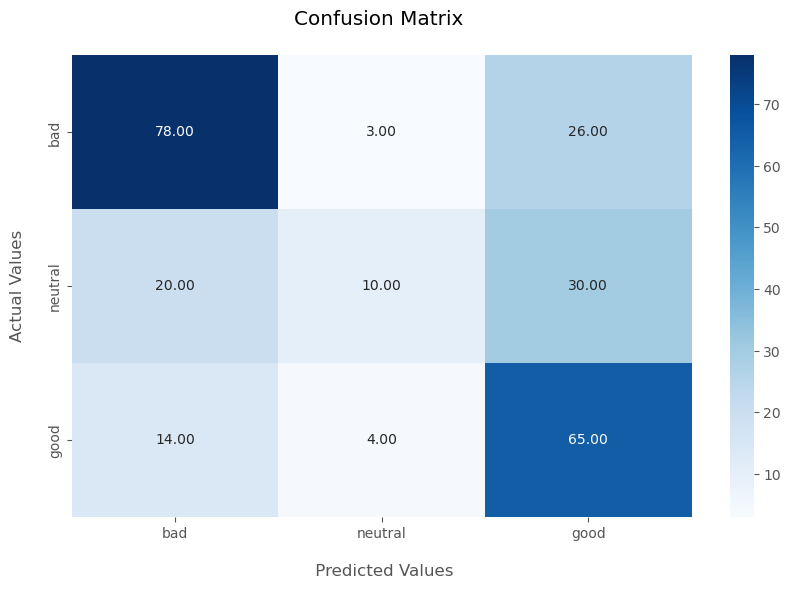

In [33]:
valid_list = list(validate_df['tweets'])
preds = model.predict(valid_list)
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(validate_df['label'],preds[0]), annot=True, fmt=".2f",cmap="Blues")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['bad','neutral','good'])
fx.yaxis.set_ticklabels(['bad','neutral','good'])
plt.show()

## Sentiment Test

In [34]:
def get_result(statement):
    result = model.predict([statement])
    pos = np.where(result[1][0] == np.amax(result[1][0]))
    pos = int(pos[0])
    sentiment_dict = {0:'Bad',1:'Neutral',2:'Good!!!'}
    print(sentiment_dict[pos])
    return

In [35]:
get_result("Skynet is here")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Bad


# Pickling Model

In [36]:
# import pickle
# pickle.dump(model, open('pickeled_model.pkl', 'wb'))


## Model Inferencing with New Data

In [37]:
new_tweets = pd.read_csv('tweets_sample_cleaned.csv')

new_tweets = new_tweets.head(5)

In [38]:
new_tweets.dtypes

Unnamed: 0          int64
tweets             object
date               object
date_year_month    object
dtype: object

In [42]:
def get_result2(statement):
    result = model.predict([statement])
    pos = np.where(result[1][0] == np.amax(result[1][0]))
    pos = int(pos[0])
    sentiment_dict = {0:'Bad',1:'Neutral',2:'Good!!!'}
    return sentiment_dict[pos]
   

In [43]:
new_tweet_sentiments = []
for i in new_tweets.index:
    new_tweet_sentiments.append(get_result2(new_tweets['tweets'][i]))
new_tweets['sentiment']=new_tweet_sentiments
        

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
new_tweets

,Unnamed: 0,tweets,date,date_year_month,sentiment
0,206164,i asked chatgpt about outlining a blog title f...,2023-02-08 05:19:02+00:00,2023-02,Good!!!
1,186137,francois jordaan a um academic integrity speci...,2023-02-11 12:31:21+00:00,2023-02,Bad
2,160656,understanding chatgpt and why it’s even bigger...,2023-02-16 08:00:14+00:00,2023-02,Bad
3,232142,ljcodes today i used chatgpt to fix a react na...,2023-02-03 14:21:28+00:00,2023-02,Good!!!
4,84473,what is gpt4 watch it now india indiancrick...,2023-03-15 16:32:12+00:00,2023-03,Bad


In [45]:
new_tweets.groupby('sentiment').count()

,Unnamed: 0,tweets,date,date_year_month
sentiment,,,,
Bad,3,3,3,3
Good!!!,2,2,2,2


In [46]:
get_result('chatgpt is great')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Good!!!
